# Logit models

Linear regressions ((ordinary least squares, or OLS)) tells us about the association between a **dependent**, or Y variable, and a set of **independent**, or X variables. Regression does not tell us anything about one variable causing another or if the correlations we find have any real meaning. It is simply a [statistical technique](https://www.statology.org/linear-regression-assumptions/) for finding a linear relationship between two variables. The meaning of that relationship is up to us and the ideas that we are working with. In finance, we usually have an economic model in mind, such as the CAPM, that gives meaning to the relationship that we find.

A **logit regression** does something similar, except that it was developed for when our dependent variable is **binary**, a Yes or No. Logistic regression is a regression model where the response variable Y is **categorical**, as opposed to **continuous**. These types of models are used for **classification**. Why do we need a new model? We want a model that can give us **probabilities** for an event. Regular regression isn't set up to do this

We will look at a type of data that is commonly used with logit models in finance: credit card default data. This data set has a **binary outcome**. Did the credit card user default? Yes or No? 1 or 0?

I start with some data from a DataCamp module on credit risk analysis. I then work the examples from the **Hull textbook, Chapters 3 and 10**. 

My first set of notes below are focused on interpreting coefficients in the model. The Hull text is focused on the predictive outcome. cd ..

We'll start with some usual set-up, bringing the data in, and taking a peak.


In [2]:
# import packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Include this to have plots show up in your Jupyter notebook.
%matplotlib inline 

# For the Hull logit
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

Let's bring in the credit card default data first.

In [ ]:
loans = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/loan_data.csv', index_col=0)  

There are no dates in this data, so no dates to parse. The first column is simply the row number, so I'll make that my index.

## Cleaning our data

Let's get started by just looking at what we have.

In [2]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29092 entries, 1 to 29092
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loan_status     29092 non-null  int64  
 1   loan_amnt       29092 non-null  int64  
 2   int_rate        26316 non-null  float64
 3   grade           29092 non-null  object 
 4   emp_length      28283 non-null  float64
 5   home_ownership  29092 non-null  object 
 6   annual_inc      29092 non-null  float64
 7   age             29092 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 2.0+ MB


We are interested in explaining the *loan_status* variable. In this data set, *loan_status = 1* means that the credit card holder has defaulted on their loan. What explains the defaults? The loan amount? Their income? Employment status? Their age?

In [3]:
loans.describe()

loan_status     loan_amnt      int_rate    emp_length    annual_inc  \
count  29092.000000  29092.000000  26316.000000  28283.000000  2.909200e+04   
mean       0.110924   9593.505947     11.004567      6.145282  6.716883e+04   
std        0.314043   6323.416157      3.239012      6.677632  6.360652e+04   
min        0.000000    500.000000      5.420000      0.000000  4.000000e+03   
25%        0.000000   5000.000000      7.900000      2.000000  4.000000e+04   
50%        0.000000   8000.000000     10.990000      4.000000  5.642400e+04   
75%        0.000000  12250.000000     13.470000      8.000000  8.000000e+04   
max        1.000000  35000.000000     23.220000     62.000000  6.000000e+06   

                age  
count  29092.000000  
mean      27.702117  
std        6.231927  
min       20.000000  
25%       23.000000  
50%       26.000000  
75%       30.000000  
max      144.000000

Note the units. Loan amount appears to be in dollars. The max of \$35,000 reflects the general limit on credit card borrowing - these aren't mortgages. Interest rate is in percents. The median credit card rate in this sample is 10.99%. Employment length is in years, as is age. Annual income is in dollars. Note the max values for *annual_inc* and *age*. Seems odd.

Home ownership and grade do not appear, since they are text variables, not numeric. Grade is some kind of overall measure of loan quality.

Let's convert the two object variables to [categorical variables](https://www.tutorialspoint.com/python_pandas/python_pandas_categorical_data.htm) so that we can deal with them. This code puts all of the **object** columns into a list and then loops through that list to change those columsn to type **category**. 

In [4]:
list_str_obj_cols = loans.columns[loans.dtypes == 'object'].tolist()
for str_obj_col in list_str_obj_cols:
    loans[str_obj_col] = loans[str_obj_col].astype('category')

loans.dtypes

loan_status          int64
loan_amnt            int64
int_rate           float64
grade             category
emp_length         float64
home_ownership    category
annual_inc         float64
age                  int64
dtype: object

Looks good! I'm now going to add `include='all'` to `describe` to give more information about these categorical variables.


In [5]:
loans.describe(include='all')

loan_status     loan_amnt      int_rate  grade    emp_length  \
count   29092.000000  29092.000000  26316.000000  29092  28283.000000   
unique           NaN           NaN           NaN      7           NaN   
top              NaN           NaN           NaN      A           NaN   
freq             NaN           NaN           NaN   9649           NaN   
mean        0.110924   9593.505947     11.004567    NaN      6.145282   
std         0.314043   6323.416157      3.239012    NaN      6.677632   
min         0.000000    500.000000      5.420000    NaN      0.000000   
25%         0.000000   5000.000000      7.900000    NaN      2.000000   
50%         0.000000   8000.000000     10.990000    NaN      4.000000   
75%         0.000000  12250.000000     13.470000    NaN      8.000000   
max         1.000000  35000.000000     23.220000    NaN     62.000000   

       home_ownership    annual_inc           age  
count           29092  2.909200e+04  29092.000000  
unique              4           NaN           NaN  
top              RENT           NaN           NaN  
freq            14692           NaN           NaN  
mean              NaN  6.716883e+04     27.702117  
std               NaN  6.360652e+04      6.231927  
min               NaN  4.000000e+03     20.000000  
25%               NaN  4.000000e+04     23.000000  
50%               NaN  5.642400e+04     26.000000  
75%               NaN  8.000000e+04     30.000000  
max               NaN  6.000000e+06    144.000000

This doesn't show us all of the possible values, but at least we can see the number of values that aren't missing, as well as a count of unique values. Let's get a list of possible values for each categorical variable.

In [6]:
loans['grade'].value_counts()

A    9649
B    9329
C    5748
D    3231
E     868
F     211
G      56
Name: grade, dtype: int64

In [7]:
loans['home_ownership'].value_counts()

RENT        14692
MORTGAGE    12002
OWN          2301
OTHER          97
Name: home_ownership, dtype: int64


We can use `sns.pairplot` from the `seaborn` library to get a nice visualization of the relationships between our variables. The diagonal plots show the **denisity plots** for that one variable, but split between *loan_status*. The off-diagonal plots show the relationship between two of the explanatory (X) variables, but with each observation color-coded based on a third variable, their default status. 

Orange means that the person has defaulted. 

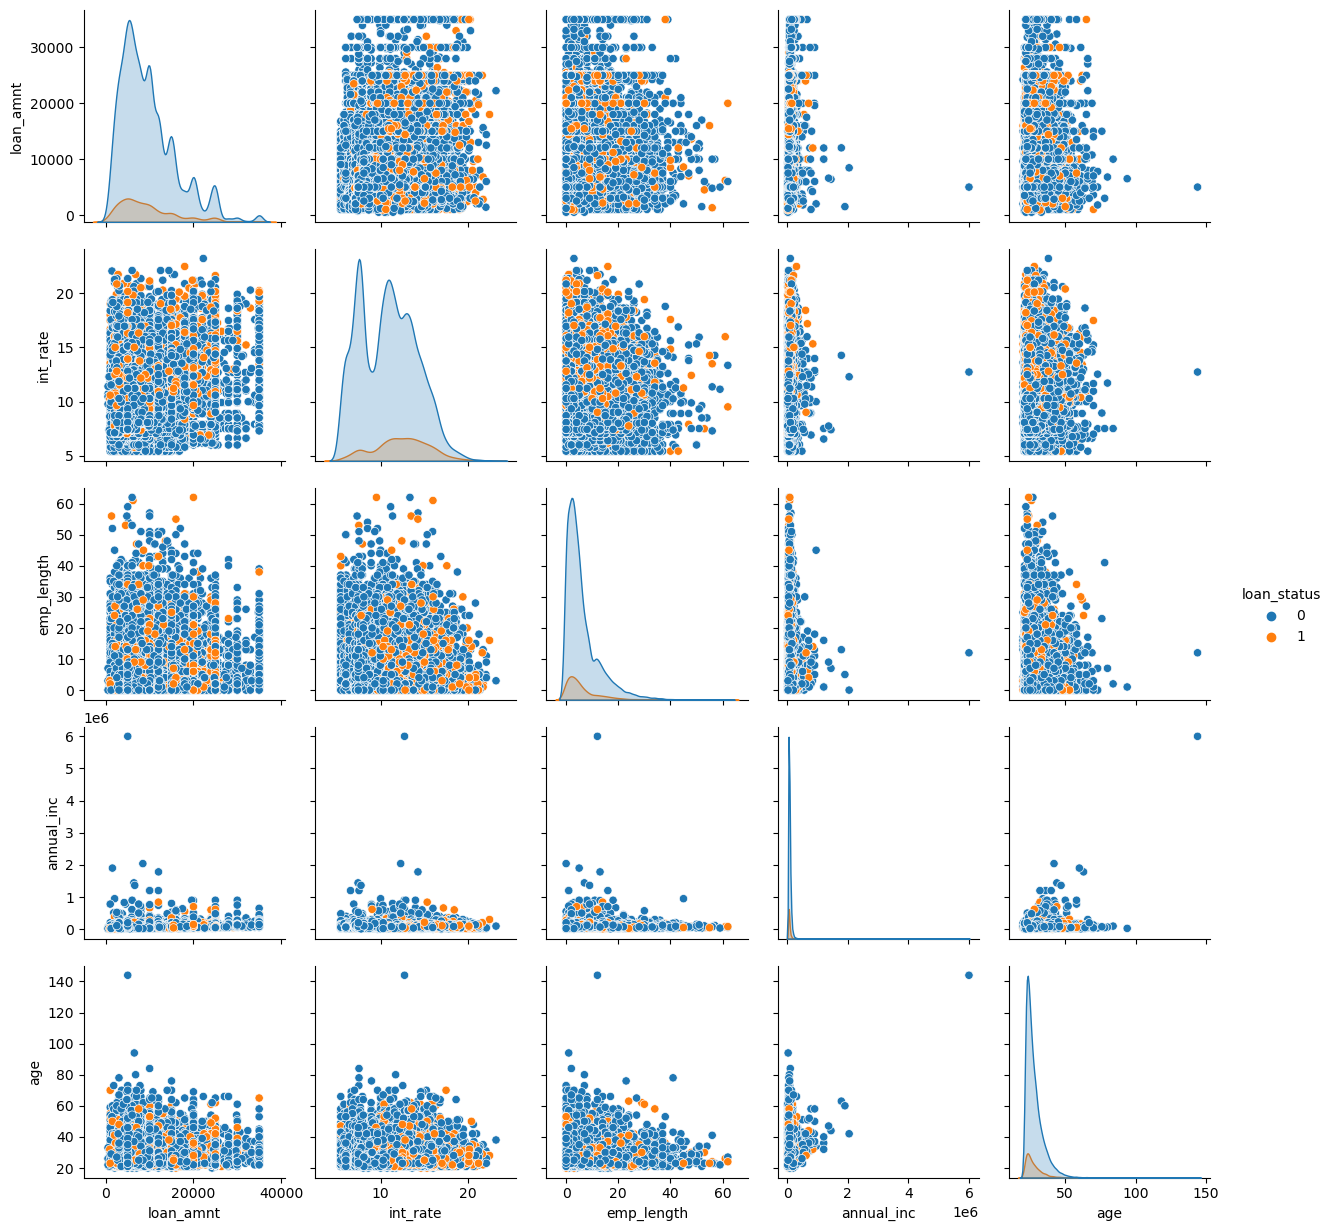

In [8]:
sns.pairplot(loans, hue='loan_status');


What jumps out to you? First, I see some outliers in age. Someone is over 140 years old in the data! We should drop that observation.

There's also one individual with a really large annual income. We could also drop that one observation. Outlier observations can overly influence our regression results, though there are techniques for dealing with that. 

We can also visually see some of the relationships. Look up and down the *int_rate* column. Generally, there are more orange dots when the interest rate is higher. Look at the second row, second column. The mean of the smaller density is to the right of the larger one. The smaller one has an orange border and shows the distribution of interest rates on the loans that defaulted.

Look at the third row, second column. There are more orange dots in the higher interest rate, shorter employment length part of the distribution. Look at the fifth row, second column. Loans that defaulted tended to be younger and with higher interest rates.

I am going to clean up two of the outliers - the one for annual income and the one for age. I'll also drop any row with a missing value. 

When done, I'll re-check my data.

In [9]:
loans = loans[loans['annual_inc'] < 6000000]
loans = loans[loans['age'] < 144]

loans = loans.dropna()

loans.describe(include='all')


loan_status     loan_amnt      int_rate  grade    emp_length  \
count   25570.000000  25570.000000  25570.000000  25570  25570.000000   
unique           NaN           NaN           NaN      7           NaN   
top              NaN           NaN           NaN      A           NaN   
freq             NaN           NaN           NaN   8412           NaN   
mean        0.109190   9655.154478     11.034409    NaN      6.127219   
std         0.311884   6324.540307      3.228964    NaN      6.653610   
min         0.000000    500.000000      5.420000    NaN      0.000000   
25%         0.000000   5000.000000      7.900000    NaN      2.000000   
50%         0.000000   8000.000000     10.990000    NaN      4.000000   
75%         0.000000  12500.000000     13.480000    NaN      8.000000   
max         1.000000  35000.000000     23.220000    NaN     62.000000   

       home_ownership    annual_inc           age  
count           25570  2.557000e+04  25570.000000  
unique              4           NaN           NaN  
top              RENT           NaN           NaN  
freq            13015           NaN           NaN  
mean              NaN  6.750489e+04     27.695190  
std               NaN  5.214082e+04      6.163362  
min               NaN  4.000000e+03     20.000000  
25%               NaN  4.000000e+04     23.000000  
50%               NaN  5.700600e+04     26.000000  
75%               NaN  8.000400e+04     30.000000  
max               NaN  2.039784e+06     84.000000

That seems better. Note that each variable now has the same count. Only rows with all of the information are included. This isn't necessarily best practices when it comes to data. You want to know why your data are missing. You can sometimes fill in the missing data using a variety of methods, as well. 

We can also use the basic `pd.crosstabs` function from `pandas` to look at variables across our categorical data.


In [10]:
pd.crosstab(loans['loan_status'], loans['home_ownership'])

home_ownership  MORTGAGE  OTHER   OWN   RENT
loan_status                                 
0                   9506     69  1740  11463
1                   1019     16   205   1552

We can **normalize** these counts as well, either over all values, by row, or by column. 

In [11]:
pd.crosstab(loans['loan_status'], loans['home_ownership'], normalize = 'all')

home_ownership  MORTGAGE     OTHER       OWN      RENT
loan_status                                           
0               0.371764  0.002698  0.068048  0.448299
1               0.039851  0.000626  0.008017  0.060696

This tells us that about 6% of our sample are renters who defaulted. We can try normalizing by column, too.

In [12]:
pd.crosstab(loans['loan_status'], loans['home_ownership'], normalize = 'columns')

home_ownership  MORTGAGE     OTHER       OWN      RENT
loan_status                                           
0               0.903183  0.811765  0.894602  0.880753
1               0.096817  0.188235  0.105398  0.119247

Now, each column adds up to 1. 11.9% of all renters in the sample defaulted. 

Finally, we can look at the **margins**. These add up values by row and column. 

In [13]:
pd.crosstab(loans['loan_status'], loans['home_ownership'], normalize = 'all', margins = True)

home_ownership  MORTGAGE     OTHER       OWN      RENT      All
loan_status                                                    
0               0.371764  0.002698  0.068048  0.448299  0.89081
1               0.039851  0.000626  0.008017  0.060696  0.10919
All             0.411615  0.003324  0.076066  0.508995  1.00000

So, 10.9% of the full sample defaulted on their loans. About 51% are the full sample are renters. And, about 6% of renters defaulted. 

You can play around with the options to get the counts or percents that you want.

## Linear regression with a binary outcome

Now, let's run a regular linear regression to see what the relationship between loan status (default = 1) and annual income is. We are going to use the `statsmodel` library. 

In [14]:
results_ols = smf.ols("loan_status ~ annual_inc", data=loans).fit()
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     67.76
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           1.93e-16
Time:                        13:29:19   Log-Likelihood:                -6455.7
No. Observations:               25570   AIC:                         1.292e+04
Df Residuals:                   25568   BIC:                         1.293e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1300      0.003     40.781      0.0

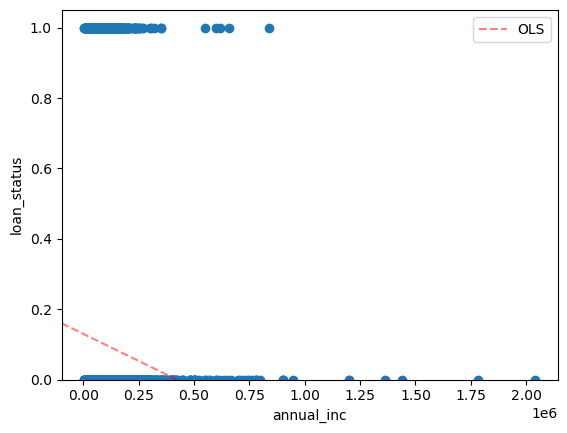

In [15]:
fig, ax = plt.subplots()
ax.scatter(loans["annual_inc"], loans["loan_status"])
sm.graphics.abline_plot(model_results=results_ols, ax=ax, color="red", label="OLS", alpha=0.5, ls="--")
ax.legend()
ax.set_xlabel("annual_inc")
ax.set_ylabel("loan_status")
ax.set_ylim(0, None)
plt.show()

Well, that sure looks strange! Linear regression shows loan status going negative!

Let's do the same thing with `seaborn`. It's very easy to add a regression line, like you would in Excel. 

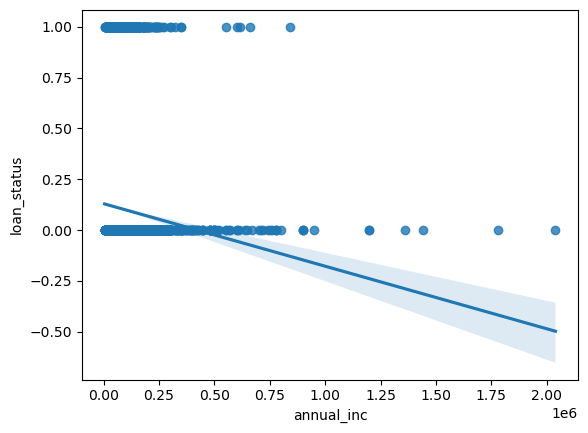

In [16]:
sns.regplot(x="annual_inc", y="loan_status", data=loans);

Yeah, that really doesn't make sense. `seaborn` lets us also add the fit from a logistic regression, though. 

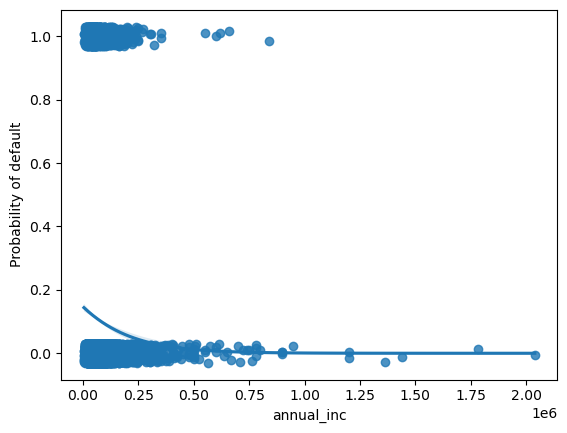

In [17]:
sns.regplot(x="annual_inc", y="loan_status", data=loans, logistic=True, y_jitter=.03)
plt.ylabel("Probability of default");

OK, that still looks a bit strange, but at least loan status is never below 0!

### Categorical variables, again

We'll add the other variables to the regression, for completeness. To do this, though, I'm going to take my categorical variables and create new **dummy or indicator variables**. This will take the categories and create new columns. These new columns will take the value of 1 or 0, depending on whether or not that observation is in that category.

I'll use [pd.get_dummies](https://www.sharpsightlabs.com/blog/pandas-get-dummies/) to do this. I then concatenate, or combine, this new set of indicator variables to my original data. The `prefix=` helps me name the new variables.


In [18]:
loans= pd.concat((loans, pd.get_dummies(loans['grade'], prefix='loan_grade')), axis = 1)
loans= pd.concat((loans, pd.get_dummies(loans['home_ownership'], prefix='home')), axis = 1)

You don't have to create the numeric indicator variables for the regression models. However, when dealing with indicators, you need to drop one of them from the model. For example, for home ownership, you can't include *home_mortgage*, *home_rent*, *home_own*, and *home_other*. You always have to drop one category, or the regression won't work. This is because the four variables together are [perfectly multicollinear](https://www.dummies.com/article/business-careers-money/business/economics/perfect-multicollinearity-and-your-econometric-model-156469/). See Chapter 3 of the Hull text for more. 

I find it easier sometimes to manipulate the model when I have a distinct indicator variable for my categorical variables. You can also use the `treatment=` option when specifying a variable as categorical directly in the model.

For example, let me run the OLS model with *home_ownership* included as a categorical variable. 

In [19]:
results_ols = smf.ols("loan_status ~ annual_inc + home_ownership", data=loans).fit()
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     21.92
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           4.44e-18
Time:                        13:31:02   Log-Likelihood:                -6445.8
No. Observations:               25570   AIC:                         1.290e+04
Df Residuals:                   25565   BIC:                         1.294e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

That worked just fine. But, notice how *home_ownership[T.Mortgage]* is missing? The model automatically dropped it. So, the other *home_ownership* values are relative to having a mortgage. This may be just fine, of course! We can interpret the coefficient for renting, for example, as meaning that renters are more likely to default than those that have a mortgage. 

Here, I'll use my indicator variables and run a fully-specified model.

In [20]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25570 entries, 1 to 29091
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   loan_status     25570 non-null  int64   
 1   loan_amnt       25570 non-null  int64   
 2   int_rate        25570 non-null  float64 
 3   grade           25570 non-null  category
 4   emp_length      25570 non-null  float64 
 5   home_ownership  25570 non-null  category
 6   annual_inc      25570 non-null  float64 
 7   age             25570 non-null  int64   
 8   loan_grade_A    25570 non-null  uint8   
 9   loan_grade_B    25570 non-null  uint8   
 10  loan_grade_C    25570 non-null  uint8   
 11  loan_grade_D    25570 non-null  uint8   
 12  loan_grade_E    25570 non-null  uint8   
 13  loan_grade_F    25570 non-null  uint8   
 14  loan_grade_G    25570 non-null  uint8   
 15  home_MORTGAGE   25570 non-null  uint8   
 16  home_OTHER      25570 non-null  uint8   
 17  home_OWN    

I will exclude the top rated A loan indicator and the indicator for renting. Therefore, the other indicator variables will be relative to the excluded one.

In [21]:
results_ols = smf.ols("loan_status ~ loan_amnt + int_rate + emp_length + annual_inc + age + loan_grade_B + loan_grade_C + loan_grade_D + loan_grade_E + loan_grade_F + loan_grade_G + home_MORTGAGE + home_OWN + home_OTHER", data=loans).fit()
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     52.76
Date:                Tue, 26 Mar 2024   Prob (F-statistic):          2.32e-146
Time:                        13:31:09   Log-Likelihood:                -6125.3
No. Observations:               25570   AIC:                         1.228e+04
Df Residuals:                   25555   BIC:                         1.240e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0348      0.017      2.033

The interpretation of the signs on the coefficients is relatively straightforward. Larger credit card loans are less likely to default. Why? Lending is **endogenous** - it is chosen by the credit card company. They are more likely to allow larger balances for people less likely to default, all other things equal. Similarily, higher interest rates are related to more defaults. Larger annual incomes are associated with a smaller default rate. Lower loan grades, relative to A, are associated with more defaults. Finally, mortgage vs. renting doesn't seem to be that different, once you include all of these other variables.

## Logit models

OK, so let's look at a [logit model](https://www.andrewvillazon.com/logistic-regression-python-statsmodels/#fitting-a-logistic-regression). We can look at the signs of the coefficients from the OLS model, but we can't really interpret much else. Those coefficients are not probabilities. 

The true probability of defaulting must fall between 0 and 1. A **logit function**, show below, will satisfy this requirement. 

\begin{align}
{\displaystyle \mathbb{P}(Y=1\mid X) = \frac{1}{1 + e^{-X'\beta}}}
\end{align}

The left-hand side is the probability that Y = 1, or, in our case, that a loan is in default, **conditional** on the X variables, or the variables that we are using to predict loan status. The right-hand side is the function that **links** our X variables to the probability that Y = 1.

We will use `smf.logit` to estimate our logit model. This is an example of using a **generalized linear model (GLM)**, a class of models that includes logistic regression. You will also see logits described as **binomial** model. 

In the background, GLM uses **maximum likelihood** to fit the model. The basic intuition behind using maximum likelihood to fit a logistic regression model is as follows: 

We seek estimates for $\beta_0$ an $\beta_1$ that get us a predicted probability of default for each individual, $p(x_i)$, that corresponds as closely as possible to the individual’s actual observed default status. In other words, we plug in beta estimates until we get numbers "close" to 1 for those that default and "close" to zero for those that do not. This is done using what is called a **liklihood function**.

Ordinary least squares regression (OLS) actually works in a similar manner, where betas are chosen to minimize the sum of squared residuals (errors).

Essentially, we pick a model that we think can explain our data. This could be OLS, logit, or something else. Then, we find the parameters to plug into that model that give us the best possible predicted values based on minimizing some kind of error function.

Let's look at a logit with a discrete variable and a continuous X variable separately, in order to better understand how to interpret the output. 

### Logit with a discrete variable

We can start simply, again. This time, I'm going to just use the indicator for whether or not the person rents.

In [22]:
results_logit = smf.logit("loan_status ~ home_RENT", data = loans).fit()
print(results_logit.summary())

Optimization terminated successfully.
         Current function value: 0.344279
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                25570
Model:                          Logit   Df Residuals:                    25568
Method:                           MLE   Df Model:                            1
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                0.001567
Time:                        13:31:27   Log-Likelihood:                -8803.2
converged:                       True   LL-Null:                       -8817.0
Covariance Type:            nonrobust   LLR p-value:                 1.473e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2110      0.030    -73.913      0.000      -2.270      -2.152
home_RENT      0.2114      0.

We didn't include renting in the linear model above, as it was the omitted indicator. But, here we can see that renting is associated with higher probability of default **relative to all of the other possibilities** and when not including any other variables in the model. 

Also note that we don't have *t*-statistics. With logit, you can *z*-scores. You can look at the p-values to see how you should interpret the score. The hypothesis is the same as in linear regression: can we reject the null hypothesis that this coefficient is zero?

The output from the logit regression is still hard to interpret, though. What does the coefficient on home_RENT of 0.2114 mean? This is a **log odds ratio**. Let's convert this to an **odds ratio**, which is easier to think about.

An odds ratio is defined as: 

\begin{align}
{\displaystyle \text{odds(success)} = \frac{p}{1-p}}
\end{align}


where p = probability of the event happening. So, an 80% chance of happening = .8/.2 = 4:1 odds. 1:1 odds is a 50/50 chance. The logit model gives us the log of this number. So, we can use the inverse of the log, the natural number e, to "undo" the log and get us the odds.

In [23]:
odds_ratios = pd.DataFrame(
    {
        "OR": results_logit.params,
        "Lower CI": results_logit.conf_int()[0],
        "Upper CI": results_logit.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

                 OR  Lower CI  Upper CI
Intercept  0.109589  0.103349  0.116206
home_RENT  1.235453  1.141559  1.337070


What do these numbers mean? If someone rents, this increases the odds of default by about 1.24 versus all other options.

For more about interpreting odds, see [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/).

Odds ratios are **not probabilities**. Let's calculate the change in the probability of default as you from 0 to 1 for home_ownership_RENT. The [.get_margeff](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.DiscreteResults.get_margeff.html) function finds **marginal effects** and let's us move from odds ratios to probabilities.

Things get a bit complicated here. We have to find the marginal effect **at some point**, like the mean of the variable. This is like in economics, when you find [price elasticity](https://en.wikipedia.org/wiki/Price_elasticity_of_demand). I'm specifying that I have a dummy variable that I want to change and that I want the proportional change in *loan_status* for a change in *home_RENT*. This is the `eydx` specification.

In [24]:
p_marg_effect = results_logit.get_margeff(at='mean', method="eydx", dummy=True)
p_marg_effect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            loan_status
Method:                          eydx
At:                              mean
==============================================================================
            d(lny)/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
home_RENT      0.1884      0.036      5.238      0.000       0.118       0.259
==============================================================================
"""

You can interpret this as "going from not renting to renting is associated with an 18.84% increase *loan_status*." You can also specify `dydx`, which is the default.

In [25]:
p_marg_effect = results_logit.get_margeff(at='mean', method="dydx", dummy=True)
p_marg_effect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            loan_status
Method:                          dydx
At:                              mean
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
home_RENT      0.0205      0.004      5.260      0.000       0.013       0.028
==============================================================================
"""

You can interpret this as "going from not renting to renting is associated with an 0.0205 increase in *loan_status* from the mean of *loan_status*."

### Logit with a continuous variable

We can also look at a continuous variable, like annual income.

In [26]:
results_logit = smf.logit("loan_status ~ annual_inc", data = loans).fit()
print(results_logit.summary())

Optimization terminated successfully.
         Current function value: 0.342899
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                25570
Model:                          Logit   Df Residuals:                    25568
Method:                           MLE   Df Model:                            1
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                0.005569
Time:                        13:32:05   Log-Likelihood:                -8767.9
converged:                       True   LL-Null:                       -8817.0
Covariance Type:            nonrobust   LLR p-value:                 3.765e-23
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7618      0.041    -43.111      0.000      -1.842      -1.682
annual_inc -5.309e-06   5.89e

Let's find our odds ratio for annual income. However, if we do that math exactly like above, we'll find the incremental odds change for a dollar more in annual income. That's going to be small! However, it is easy to change the increment for our continuous variable. 

In [27]:
increment = 10000

odds_ratios = pd.DataFrame(
    {
        "OR": results_logit.params * increment,
        "Lower CI": results_logit.conf_int()[0]* increment,
        "Upper CI": results_logit.conf_int()[1]* increment,
    }
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

                  OR  Lower CI  Upper CI
Intercept   0.000000  0.000000  0.000000
annual_inc  0.948297  0.937414  0.959307


We can read this number as "Increasing income by $10,000 reduces the odds of default by 1-0.948, or 0.052 (5.2%)."

We can also do marginal probabilities. I'll use the `eyex` method which tells us: If annual income increases by 1% from the mean value, what is the percentage change in the probability of default?

In [28]:
p_marg_effect = results_logit.get_margeff(at='mean', method="eyex")
p_marg_effect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            loan_status
Method:                          eyex
At:                              mean
=================================================================================
           d(lny)/d(lnx)    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
annual_inc       -0.3200      0.036     -8.976      0.000      -0.390      -0.250
=================================================================================
"""

If annual income, starting at the mean value, increases by 1%, then the probability of default drops by 0.32%. 

### Combining variables in a logit

Let's look at both annual income and renting together. It's good to get a feel for how to deal with both discrete and continuous variables.

I'm going to use the `C` categorical method and specify the "treatment", or omitted, indicator. This is instead of using my dummy variables that I created above. I just want to show you the different ways of doing the same thing.

In [29]:
results_logit = smf.logit("loan_status ~ loan_amnt + int_rate + emp_length + annual_inc + age + C(home_ownership, Treatment('MORTGAGE')) + C(grade, Treatment('A'))", data = loans).fit()
print(results_logit.summary())

Optimization terminated successfully.
         Current function value: 0.330446
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                25570
Model:                          Logit   Df Residuals:                    25555
Method:                           MLE   Df Model:                           14
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                 0.04168
Time:                        13:32:30   Log-Likelihood:                -8449.5
converged:                       True   LL-Null:                       -8817.0
Covariance Type:            nonrobust   LLR p-value:                8.432e-148
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                     

Interpretation is similar. With all of the other variables included, renting doesn't seem to matter much for the probability of default vs. having a mortgage, since that coefficient is not significant. Remember, having a mortgage is the omitted indicator, so everything is relative to that. Notice how as you move down in loan grade that the probability of default increases, relative to being in the top category, "A", which was the omitted indicator. Annual income is again very significant and negative.

In [30]:
p_marg_effect = results_logit.get_margeff(at='overall', method="dydx")
p_marg_effect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            loan_status
Method:                          dydx
At:                           overall
=====================================================================================================================
                                                       dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
C(home_ownership, Treatment('MORTGAGE'))[T.OTHER]     0.0523      0.027      1.942      0.052      -0.000       0.105
C(home_ownership, Treatment('MORTGAGE'))[T.OWN]      -0.0078      0.008     -0.998      0.318      -0.023       0.008
C(home_ownership, Treatment('MORTGAGE'))[T.RENT]     -0.0018      0.004     -0.413      0.679      -0.010       0.007
C(grade, Treatment('A'))[T.B]                         0.0331      0.009      3.713      0.000       0.016       0.051
C(grade, Treatment('A'))[T.C]                         0.0479      0.013      3.700      0.000       0.023       0.073
C(grade, Treatment('A'))[T.D]                         0.0574      0.016      3.492      0.000       0.025       0.090
C(grade, Treatment('A'))[T.E]                         0.0641      0.021      3.109      0.002       0.024       0.104
C(grade, Treatment('A'))[T.F]                         0.0976      0.027      3.625      0.000       0.045       0.150
C(grade, Treatment('A'))[T.G]                         0.1203      0.037      3.255      0.001       0.048       0.193
loan_amnt                                         -1.494e-07   3.42e-07     -0.437      0.662   -8.19e-07    5.21e-07
int_rate                                              0.0082      0.002      4.347      0.000       0.005       0.012
emp_length                                            0.0006      0.000      2.175      0.030    6.41e-05       0.001
annual_inc                                        -5.493e-07   6.48e-08     -8.477      0.000   -6.76e-07   -4.22e-07
age                                                  -0.0006      0.000     -1.748      0.081      -0.001    6.87e-05
=====================================================================================================================
"""

## Hull, Chapters 3 and 10. Logit. 

As we've seen, logit models are examples of **classification models**. Chapter 3.9 starts with the logit sigmoid function and how the model works. This is similar to the discussion above. He also notes that you can use our ideas from Ridge and Lasso models with a logit. 

Chapter 3.10 talks about **class imbalance**. This comes up when the even that we are trying to predict is rare. This is often the case - many diseases are rare, credit default is rare. Your **unconditional probability** is going to be something like 99.9% of the time you don't have the disease or that the credit card holder doesn't default. We're trying to use machine learning tools to see if we can improve on that. 

Let's bring in the data that Hull uses in the text. We'll give them each some actual column names look at each data set.

The data has four features. We are trying to predict *loan_status*.

The data has already been split into training set, validation set, and test set. There are 7000 instances of the training set, 3000 instances of the validation set and 2290 instances of the test set. The four features have been labeled as: home ownership, income, dti and fico.

In [3]:
train = pd.read_excel('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/lendingclub_traindata.xlsx')
validation=pd.read_excel('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/lendingclub_valdata.xlsx')
test = pd.read_excel('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/lendingclub_testdata.xlsx')

# 1 = good, 0 = default

#give column names
cols = ['home_ownership', 'income', 'dti', 'fico', 'loan_status']

train.columns = validation.columns = test.columns = cols

In [4]:
train.head()

home_ownership    income    dti  fico  loan_status
0               1   44304.0  18.47   690            0
1               0   50000.0  29.62   735            1
2               0   64400.0  16.68   675            1
3               0   38500.0  33.73   660            0
4               1  118000.0  26.66   665            1

In [5]:
validation.head()

home_ownership    income    dti  fico  loan_status
0               0   25000.0  27.60   660            0
1               0   50000.0  21.51   715            1
2               1  100000.0   8.14   770            1
3               0   75000.0   1.76   685            0
4               1   78000.0  16.11   680            1

In [6]:
test.head()

home_ownership    income    dti  fico  loan_status
0               1   52400.0  24.64   665            1
1               1  150000.0  17.04   785            1
2               1  100000.0  20.92   710            1
3               0   97000.0  13.11   705            1
4               1  100000.0  24.08   685            0

The **target** is the value we are trying to predict. These `sklearn` methods like to store the X and y variables separately.

We are also going to **scale** our X variables. 

**Note that we don't scale the 1/0 y variables here**. These are **classifier models**. Your target is either a 1 or a 0. Our model output is going to be a **predicted probability that the target is a 1 or a 0**.

In [7]:
# remove target column to create feature only dataset
X_train = train.drop('loan_status', 1)
X_val=validation.drop('loan_status', 1)
X_test = test.drop('loan_status', 1)

# Scale data using the mean and standard deviation of the training set. 
# This is not necessary for the simple logistic regression we will do here 
# but should be done if L1 or L2 regrularization is carried out
X_test=(X_test-X_train.mean())/X_train.std()
X_val=(X_val-X_train.mean())/X_train.std()
X_train=(X_train-X_train.mean())/X_train.std()

# store target column as y-variables 
y_train = train['loan_status']
y_val=validation['loan_status']
y_test = test['loan_status']


In [8]:
X_train.head()

home_ownership    income       dti      fico
0        0.809651 -0.556232  0.053102 -0.163701
1       -1.234923 -0.451393  1.307386  1.262539
2       -1.234923 -0.186349 -0.148259 -0.639114
3       -1.234923 -0.663060  1.769728 -1.114527
4        0.809651  0.800204  0.974410 -0.956056

In [9]:
X_val.head()

home_ownership    income       dti      fico
0       -1.234923 -0.911538  1.080153 -1.114527
1       -1.234923 -0.451393  0.395077  0.628655
2        0.809651  0.468899 -1.108940  2.371837
3       -1.234923  0.008753 -1.826638 -0.322172
4        0.809651  0.063971 -0.212379 -0.480643

In [10]:
X_test.head()

home_ownership    income       dti      fico
0        0.809651 -0.407219  0.747177 -0.956056
1        0.809651  1.389190 -0.107762  2.847250
2        0.809651  0.468899  0.328707  0.470184
3       -1.234923  0.413681 -0.549855  0.311713
4        0.809651  0.468899  0.684181 -0.322172

Let's do some simple counts and percentages first. What percent of our training data have a "good" loan status? What percent are in default? I used some fancier methods above to do these percentages.

In [11]:
freq = y_train.value_counts()           # count frequency of different classes in training swet
freq/sum(freq)*100                      # get percentage of above

1    79.171429
0    20.828571
Name: loan_status, dtype: float64

Let's run the logit. We'll create the logit object and then fit the model. The logit model object has a variety of options that we could choose for it.
We'll print the intercept and the coefficients from the fitted model.

The `penalty` option lets you choose regular logit, Ridge, Lasso, or Elasticnet by setting the type of L1 or L2 penalty used. See the [sklearn manual](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for more.

In [14]:
#Create an ionstance of logisticregression named lgstc_reg 

lgstc_reg =  LogisticRegression(penalty = None, solver="newton-cg")     

# Fit logististic regression to training set

lgstc_reg.fit(X_train, y_train)                                        # fit training data on logistic regression 

print(lgstc_reg.intercept_, lgstc_reg.coef_)  

[1.41622043] [[ 0.14529381  0.03361951 -0.32404237  0.363174  ]]


In [36]:
# y_train_pred, y_val_pred, and y_test_pred are the predicted probabilities for the training set
# validation set and test set using the fitted logistic regression model

y_train_pred = lgstc_reg.predict_proba(X_train)
y_val_pred = lgstc_reg.predict_proba(X_val)
y_test_pred = lgstc_reg.predict_proba(X_test)

# Calculate maximum likelihood for training set, validation set, and test set

mle_vector_train = np.log(np.where(y_train == 1, y_train_pred[:,1], y_train_pred[:,0]))
mle_vector_val = np.log(np.where(y_val == 1, y_val_pred[:,1], y_val_pred[:,0]))
mle_vector_test = np.log(np.where(y_test == 1, y_test_pred[:,1], y_test_pred[:,0]))

# Calculate cost functions from maximum likelihoods

cost_function_training = np.negative(np.sum(mle_vector_train)/len(y_train))
cost_function_val = np.negative(np.sum(mle_vector_val)/len(y_val))
cost_function_test = np.negative(np.sum(mle_vector_test)/len(y_test))

print('cost function training set =', cost_function_training)
print('cost function validation set =', cost_function_val)
print('cost function test set =', cost_function_test)

cost function training set = 0.4911114356066864
cost function validation set = 0.48607087962794676
cost function test set = 0.4846698447947508


What is `lgstc_reg.predict_proba` returning? Let's ask Claude GPT:

> In scikit-learn, when you call lgstc_reg.predict_proba() on a trained logistic regression model (lgstc_reg), it returns the predicted probabilities of the target classes for the input samples.

> Specifically, if you have a binary logistic regression model, lgstc_reg.predict_proba(X) will return an array of shape (n_samples, 2), where n_samples is the number of input samples in X. The two columns represent the probability of the negative class (column 0) and the probability of the positive class (column 1) for each input sample.

> For example, if you have a binary logistic regression model for predicting whether an email is spam or not, and you call `probabilities = lgstc_reg.predict_proba(X_test)`, the probabilities array will have two columns, where the first column represents the probability of the email being non-spam (class 0), and the second column represents the probability of the email being spam (class 1).

We can see that below. The numbers in each row sum to 1. 

In [37]:
y_test_pred[:5]

array([[0.28275519, 0.71724481],
       [0.0660181 , 0.9339819 ],
       [0.16605263, 0.83394737],
       [0.17623257, 0.82376743],
       [0.22953939, 0.77046061]])

I'm going through this because we need to know the shape of this data and what's in it in order to use it. Let's keep just the probability that a loan is in default. That's the second column.

In [38]:
y_test_pred = y_test_pred[:,1]
y_test_pred[:5]

array([0.71724481, 0.9339819 , 0.83394737, 0.82376743, 0.77046061])

Compare this to the data structure for our actual y test values.

In [46]:
y_test[:5]

0    1
1    1
2    1
3    1
4    0
Name: loan_status, dtype: int64

Let's create a **confusion matrix**. These help us determine how good a job our model did. From the Hull text:

> The confusion matrix itself is not confusing but the terminology that accompanies it can be. The four elements of the confusion matrix are defined as follows: 

> True Positive (TP): Both prediction and outcome are positive
> False Negative (FN): Prediction is negative, but outcome is positive 
> False Positive (FP): Prediction is positive and outcome is negative 
> True Negative (TN): Prediction is negative and outcome is negative 

To do this, we need to pick a **threshold** value. This is the value where, if the predicted probability is greater, then we say we are predicting a 1, or that the outcome is true. 

In [44]:
# Set a threshold to binarize the predicted probabilities
threshold = 0.7
y_pred_binary = np.where(y_test_pred >= threshold, 1, 0)
y_pred_binary[:5]


array([1, 1, 1, 1, 1])

The [confusion matrix method](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) comes from `sklearn`. The ravel() method is useful when you need to convert a multi-dimensional array into a 1D array, for example, when passing the array to a function or algorithm that expects a 1D array as input.

In [45]:
# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

# Print the confusion matrix
print("Confusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

Confusion Matrix:
True Negatives: 116
False Positives: 361
False Negatives: 176
True Positives: 1637


We can **normalize** the counts using rows, columns, or all the data, like we did above. This turns the output into fractions. 

In [50]:
# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary, normalize="all").ravel()

# Print the confusion matrix
print("Confusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

Confusion Matrix:
True Negatives: 0.050655021834061134
False Positives: 0.15764192139737992
False Negatives: 0.07685589519650655
True Positives: 0.7148471615720524


By using "all", this normalizes across all of the data. So, 72.48% of our data gets correctly categorized as true positives. 5.06% are true negatives. The rest are misclassified as either false positives or false negatives.

Where do you set the threshold? An analyst must decide on a criterion for predicting whether loan will be good or default. This involves specifying a threshold By default this threshold is set to 0.5, i.e., loans are separated into good and bad categories according to whether the probability of no default is greater or less than 0.5. However this does not work well for an imbalanced data set such as this. It would predict that all loans are good!

Here's some code from the text that iterates over different thresholds. I was using 0.70, or 70%, above.

In [54]:
THRESHOLD = [.70, .75, .80, .85]
# Create dataframe to store resultd
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true pos rate", "true neg rate", "false pos rate", "precision", "f-score"]) # df to store results

# Create threshold row
results['THRESHOLD'] = THRESHOLD                                                                         
             
j = 0                                                                                                      

# Iterate over the 3 thresholds

for i in THRESHOLD:                                                                                       
    
    
    #lgstc_reg.fit(X_train, y_train)                                                                    
    
    
    # If prob for test set > threshold predict 1
    preds = np.where(lgstc_reg.predict_proba(X_test)[:,1] > i, 1, 0)                                      
    
    
    # create confusion matrix 
    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None) / len(y_test))*100                   # confusion matrix (in percentage)
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TP = cm[0][0]                                                                                          # True Positives
    FN = cm[0][1]                                                                                          # False Positives
    FP = cm[1][0]                                                                                          # True Negatives
    TN = cm[1][1]                                                                                          # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_test, preds) 
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)                                                                         # True negative rate
    results.iloc[j,4] = FP/(FP+TN)                                                                         # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
    
    j += 1

print('ALL METRICS')
print( results.T)

Confusion matrix for threshold = 0.7
[[71.48471616  7.68558952]
 [15.76419214  5.06550218]]
 
Confusion matrix for threshold = 0.75
[[60.82969432 18.34061135]
 [11.70305677  9.12663755]]
 
Confusion matrix for threshold = 0.8
[[42.70742358 36.4628821 ]
 [ 6.4628821  14.36681223]]
 
Confusion matrix for threshold = 0.85
[[22.7510917  56.41921397]
 [ 3.01310044 17.81659389]]
 
ALL METRICS
                       0         1         2         3
THRESHOLD            0.7      0.75       0.8      0.85
accuracy        0.765502  0.699563  0.570742  0.405677
true pos rate   0.902923   0.76834  0.539437  0.287369
true neg rate   0.243187  0.438155  0.689727  0.855346
false pos rate  0.756813  0.561845  0.310273  0.144654
precision       0.819319  0.838651  0.868561  0.883051
f-score         0.859092  0.801957  0.665532  0.433625


Check out the confusion matrix for 0.70. See how it matches my work above?

The ALL METRICS table shows the trade-off between true positive and true negative rates. My 0.70 threshold captures 90.29% of the true positives, but only 24.32% of the true negatives. The definition for these rates are in the code:

```
results.iloc[j,3] = TN/(FP+TN)                                                                         
results.iloc[j,4] = FP/(FP+TN)
```

The denominator for both rates is False Positives + True Negatives. This sum is total number of actual negative outcomes in the data. 

The *F-Score* focuses on how well positives have been identified. See the text for more.

In particular, pg. 78 has all of these definitions and a discussion of how they are used.

Finally, let's look at an **ROC curve**. The ROC curve plots True Positive Rate (y-axis) against the False Positive Rate (x-axis).

The **AUC measure**, or area under the curve, summarizes the predictive ability of the model. An AUC of 0.5 means that the model is no better than random guessing. This is represented by the dashed line on the graph.

AUC random predictions = 0.5
AUC predictions from logistic regression model = 0.6577663531841429


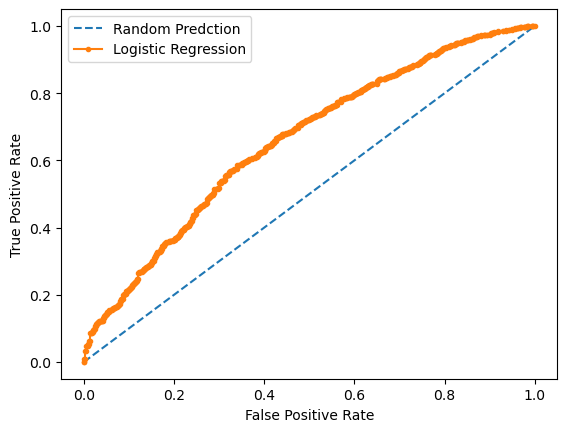

In [51]:
# Calculate the receiver operating curve and the AUC measure

lr_prob=lgstc_reg.predict_proba(X_test)
lr_prob=lr_prob[:, 1]
ns_prob=[0 for _ in range(len(y_test))]
ns_auc=roc_auc_score(y_test, ns_prob)
lr_auc=roc_auc_score(y_test,lr_prob)
print("AUC random predictions =", ns_auc)
print("AUC predictions from logistic regression model =", lr_auc)
ns_fpr,ns_tpr,_=roc_curve(y_test,ns_prob)
lr_fpr,lr_tpr,_=roc_curve(y_test,lr_prob)

plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Predction')
plt.plot(lr_fpr,lr_tpr,marker='.',label='Logistic Regression')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()